In [1]:
import numpy as np
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tqdm.notebook import tqdm
from copy import deepcopy
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sacred import Experiment
import rock_paper_scissors as rps
from rps_rl import RPCEnv, RPCAgent, Monitor, Universe

## All outcomes (sanity check)

In [2]:
rps.print_outcomes()

R vs R => tie
R vs P => R loses
R vs S => R wins
P vs R => P wins
P vs P => tie
P vs S => P loses
S vs R => S loses
S vs P => S wins
S vs S => tie


## Initial training phase

In [3]:
# environment
env = RPCEnv(noise_dim=4)

# how many agents to create?
N_AGENTS = 10

# how many games to play during test?
N_GAMES = 1000

# creating agents
AGENTS = [RPCAgent(noise_dim=env.noise_dim, identity=i) for i in range(N_AGENTS)]

# to track the performance
m = Monitor(agents=AGENTS)

In [4]:
def sample_agent():
    """Get one of the agents."""
    return np.random.choice(AGENTS)

In [5]:
# Running training games
for _ in tqdm(range(N_GAMES)):
    A1, A2 = sample_agent(), sample_agent()
    A1.do_train = True
    A2.do_train = True
    U = Universe(environment=env, agents=[A1, A2], monitor=m)
    rew = U.episode()
    del U

In [6]:
AGENTS

[<Agent id=0 wisdom=205 opponents=10>,
 <Agent id=1 wisdom=204 opponents=10>,
 <Agent id=2 wisdom=187 opponents=10>,
 <Agent id=3 wisdom=216 opponents=10>,
 <Agent id=4 wisdom=199 opponents=10>,
 <Agent id=5 wisdom=185 opponents=10>,
 <Agent id=6 wisdom=195 opponents=10>,
 <Agent id=7 wisdom=196 opponents=10>,
 <Agent id=8 wisdom=220 opponents=10>,
 <Agent id=9 wisdom=193 opponents=10>]

## Train stats

In [7]:
m.stats()

{'reward': {<Agent id=0 wisdom=205 opponents=10>: {-1: 58, 0: 70, 1: 77},
  <Agent id=1 wisdom=204 opponents=10>: {-1: 66, 0: 62, 1: 76},
  <Agent id=2 wisdom=187 opponents=10>: {-1: 71, 0: 55, 1: 61},
  <Agent id=3 wisdom=216 opponents=10>: {-1: 73, 0: 77, 1: 66},
  <Agent id=4 wisdom=199 opponents=10>: {-1: 69, 0: 71, 1: 59},
  <Agent id=5 wisdom=185 opponents=10>: {-1: 57, 0: 74, 1: 54},
  <Agent id=6 wisdom=195 opponents=10>: {-1: 76, 0: 57, 1: 62},
  <Agent id=7 wisdom=196 opponents=10>: {-1: 68, 0: 67, 1: 61},
  <Agent id=8 wisdom=220 opponents=10>: {-1: 62, 0: 76, 1: 82},
  <Agent id=9 wisdom=193 opponents=10>: {-1: 61, 0: 69, 1: 63}},
 'action': {<Agent id=0 wisdom=205 opponents=10>: [65, 74, 66],
  <Agent id=1 wisdom=204 opponents=10>: [49, 70, 85],
  <Agent id=2 wisdom=187 opponents=10>: [80, 61, 46],
  <Agent id=3 wisdom=216 opponents=10>: [81, 75, 60],
  <Agent id=4 wisdom=199 opponents=10>: [84, 50, 65],
  <Agent id=5 wisdom=185 opponents=10>: [70, 53, 62],
  <Agent id=6 w

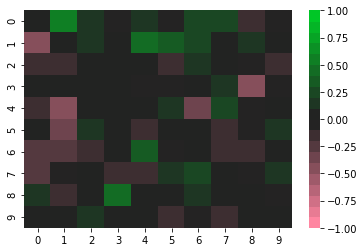

In [8]:
matrix = np.zeros((len(AGENTS), len(AGENTS)))
for i1, A1 in enumerate(AGENTS):
    for i2, A2 in enumerate(AGENTS):
        matrix[i1, i2] = np.mean(A1.reward_by_opponent[A2])
cm = sns.diverging_palette(0, 129, l=70, s=100, n=20, center="dark")
sns.heatmap(matrix, vmin=-1, vmax=1, cmap=cm)

## Running without training

In [9]:
# our agent
A = AGENTS[0]

# number of games to test for each agent
N_TEST_GAMES = 10

# to track the performance
m_test = Monitor(agents=AGENTS)

# Running training games
for _ in tqdm(range(N_TEST_GAMES)):
    for A2 in AGENTS[1:]:
        A.do_train = False
        A2.do_train = False
        U = Universe(environment=env, agents=[A, A2], monitor=m_test)
        rew = U.episode()
        del U

In [10]:
results = {x: y[AGENTS[0]] for x, y in m_test.stats().items()}

In [11]:
results['action']

[30, 32, 28]

In [12]:
rew = results['reward']

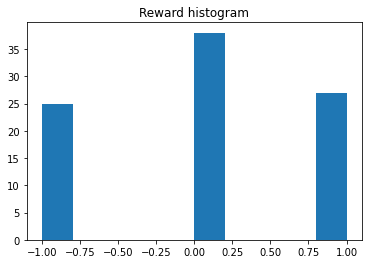

In [13]:
plt.title("Reward histogram")
plt.hist([x for x, y in rew.items() for _ in range(y)])
plt.show()

# Training with alternating + and - reward (collaboration vs competition)
1. An adversary is trained to be cooperative
2. An adversary is then switched to being competitive

In [14]:
A1 = RPCAgent(noise_dim=env.noise_dim, identity=0)
A2 = RPCAgent(noise_dim=env.noise_dim, identity=1)
AGENTS = [A1, A2]
true_opponent = AGENTS.index(A2)
print(true_opponent)

A1.do_train = False
A2.do_train = True

# to track the performance
m = Monitor(agents=AGENTS)

1


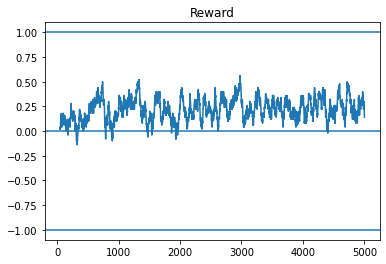

In [15]:
U = Universe(environment=env, agents=[A1, A2], monitor=m, invert_reward_2=True)
for _ in tqdm(range(5000)):
    rew = U.episode()
    
plt.title("Reward")
plt.plot(pd.Series(A1.reward_by_opponent[A2]).rolling(50).mean())
plt.axhline(0)
plt.axhline(1)
plt.axhline(-1)
plt.show()

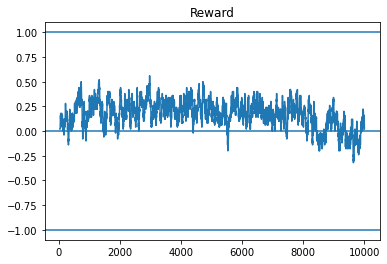

In [16]:
U = Universe(environment=env, agents=[A1, A2], monitor=m, invert_reward_2=False)
for _ in tqdm(range(5000)):
    rew = U.episode()
    
plt.title("Reward")
plt.plot(pd.Series(A1.reward_by_opponent[A2]).rolling(50).mean())
plt.axhline(0)
plt.axhline(1)
plt.axhline(-1)
plt.show()

Try with previous actions instead of random noise?